## Modules à importer

In [1]:
import math
import scipy
import pickle
import random
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
import matplotlib.pyplot as plt

from variaIa import tools
from importlib import reload
from pymage import panstarrs
from pshost import massmeasure
from variaIa import stretchevol
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from IPython.display import display, HTML, Latex
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cosmo
from astropy import units

display(HTML("<style>.container { width:100% !important; }</style>"))

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'low-z': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']

## Low-z ra, dec and zcmb to extract

In [3]:
d = pd.read_csv('../../../Data/data_cheat.csv', sep=' ')#, index_col='CID')
todl = d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])][['CID', 'RA', 'DECL', 'zCMB']].values
# Indexes 131 and 142 couldn't be recovered with PS1Target
ra = np.concatenate((todl[:, 1][:131], todl[:, 1][132:142],
                    todl[:, 1][143:]), axis=None)
dec = np.concatenate((todl[:, 2][:131], todl[:, 2][132:142],
                    todl[:, 2][143:]), axis=None)
zcmb = np.concatenate((todl[:, 3][:131], todl[:, 3][132:142],
                    todl[:, 3][143:]), axis=None)

## Set cutout size depending on redshift

d_Mpc_rad = cosmo.angular_diameter_distance(zcmb)
rad_to_arcsec = (np.pi/180*3600)**(-1)
d_Mpc_per_arcsec = d_Mpc_rad*rad_to_arcsec
d_Mpc_per_pixel = d_Mpc_per_arcsec*pix_arc
nb_pix = np.ceil((100./d_Mpc_per_pixel).value)
redownload = nb_pix > 240

### Advanced cutout selection using HG ellipses parameters

In [10]:
mmcls = []
for i in range(len(ra)):
    mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
    mm.get_hostgalaxy_params()
    mmcls.append(mm)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/photometry.py:1352: UserWarning: Automatic Threshold lowered for too few sources has been detected 
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/tools.py:130: RuntimeWarning: invalid value encountered in log10
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/collections/photodiagnostics.py:586: UserWarning: 3937/10000 color samplers will be changed to the prior distribution as they have negative flux
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/tools.py:134: RuntimeWarning: invalid value encountered in log10
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/collections/photodiagnostics.py:586: UserWarning: 5936/10000 color samplers will be changed to the prior distribu

pickle.dump(mmcls, open('../../../Data/mmcls', 'wb'))

In [7]:
with open('../../../Data/mmcls', 'rb') as f:
    mmcls = pickle.load(f)

#### Get current sizes

In [50]:
current_size = []
for i in range(len(zcmb)):
    current_size.append(len(pscls[i].imgcutout['r'].data))

In [52]:
np.array(needed_size)-np.array(current_size)

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  69,   0,   0,   0,   0,
        97,   0,   0,   0,  31,   0,   0,   0,   0,  77,  56,   0,   0,
        77,   0,   0,  53,   0,   0, 191,   0,   0,   0, 130,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  79,   0, 133, 290,
         0,   0,   0,   0,  85,   0,  76,  75,   0,   0,  98, 143,   0,
         0,   0,   0,   0,  40,   0, 123,   0,   0,   0,   0,   0,   0,
         6,   0,   0,   0,   0,   0,   0,   0,   0, 178,   0,   0,   0,
         0,   0, 117,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
         0,   0,  71, 120,   0,   0,   0,   0,  91, 146,   0,   0,   0,
         0,   0,   0,   0,  74, 189,   0,   0, 156,   0,  79,  74,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 108,   0,
       133,   0,   0, 189, 186,  88, 168, 136,  47, 179,  63,   0, 178,
        64])

#### Get ellipses of all host galaxies

In [25]:
all_hg_ell_params = []
for i in range(len(zcmb)):
    all_hg_ell_params.append(mmcls[i].hg_ellipse)
    
scaleup = 4

all_hg_ell = []
for i in range(len(zcmb)):
    all_hg_ell.append(Ellipse([all_hg_ell_params[i][0], all_hg_ell_params[i][1]],
                              2*all_hg_ell_params[i][2]*scaleup,
                              2*all_hg_ell_params[i][3]*scaleup,
                              all_hg_ell_params[i][4]*units.rad.to('deg')))

#### Compute needed size

In [26]:
vertices = []
redownload = []
needed_size = []
for i in range(len(zcmb)):
    # Get the path
    path = all_hg_ell[i].get_path()
    # Get the list of path vertices
    vertices.append(path.vertices.copy())
    # Transform the vertices so that they have the correct coordinates
    vertices[-1] = all_hg_ell[i].get_patch_transform().transform(vertices[-1])
    # Take indexes of farthest vertices
    ind_xmin = np.argmin(vertices[-1][:,0])
    ind_xmax = np.argmax(vertices[-1][:,0])
    ind_ymin = np.argmin(vertices[-1][:,1])
    ind_ymax = np.argmax(vertices[-1][:,1]) 
    # Compute distance from center to each farthest vertices
    top = np.abs(vertices[-1][ind_ymax] - [current_size[i]/2, current_size[i]/2])
    bottom = np.abs(vertices[-1][ind_ymin] - [current_size[i]/2, current_size[i]/2])
    left = np.abs(vertices[-1][ind_xmin] - [current_size[i]/2, current_size[i]/2])
    right = np.abs(vertices[-1][ind_xmax] - [current_size[i]/2, current_size[i]/2])
    tblr = [top, bottom, left, right]
    # Check if the farthest of the farthest vertices is outside the box,
    # and set needed size to twice the farthest distance
    if np.max(tblr) > current_size[i]/2:
        redownload.append(True)
        needed_size.append(int(np.ceil(2*np.max(tblr))))
    # If not, keep the current size
    else:
        redownload.append(False)
        needed_size.append(current_size[i])

## (Re)downloading data

#pscls = []
for i in range(len(ra)):
    pscls.append(panstarrs.PS1Target.from_coord(ra[i], dec[i]))
    pscls[-1].download_cutout(size=nb_pix[i], load_weight=True)

In [61]:
for i, istrue in enumerate(redownload):
    print(i)
    if istrue:
        pscls[i].download_cutout(size=needed_size[i], load_weight=True, run_sep=False);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
downloading BytesIO
downloading BytesIO


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


22
23
24
25
26
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


27
28
29
30
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


31
32
33
34
35
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


36
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


37
38
39
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


40
41
42
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


43
44
45
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


46
47
48
49
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


50
51
52
53
54
55
56
57
58
59
60
61
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


62
63
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


64
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


65
66
67
68
69
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


70
71
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


72
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


73
74
75
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


76
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


77
78
79
80
81
82
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


83
84
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


85
86
87
88
89
90
91
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


92
93
94
95
96
97
98
99
100
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


101
102
103
104
105
106
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


107
108
109
110
111
112
113
114
115
116
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


117
118
119
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


120
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


121
122
123
124
125
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


126
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


127
128
129
130
131
132
133
134
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


135
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


136
137
138
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


139
140
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


141
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


142
143
144
145
146
147
148
149
150
151
152
153
154
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


155
156
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


157
158
159
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


160
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


161
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


162
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


163
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


164
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


165
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


166
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


167
168
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


169
downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


downloading BytesIO
downloading BytesIO


In [65]:
for i in range(len(pscls)):
    print(i)
    pscls[i].sep_extract()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


Exception: internal pixel buffer full: The limit of 300000 active object pixels over the detection threshold was reached. Check that the image is background subtracted and the detection threshold is not too low. If you need to increase the limit, use set_extract_pixstack.

In [70]:
pscls[i].imgcutout['r']._get_sep_threshold_(None)

0.13731003578762951

In [110]:
np.argmax(pscls[17]._sep.sepobjects.get_ellipse_values().T, axis=0)

array([ 35, 134,  75,  75, 103])

In [111]:
pscls[17]._sep.sepobjects.get_ellipse_values().T[75]

array([ 4.79322956e+02,  6.25811365e+02,  5.95176353e+01,  4.55129318e+01,
       -2.77595460e-01])

In [125]:
pscls[17]._sep.sepobjects._handler[pscls[17]._sep.sepobjects.list_id[75]].get(['a'])

[59.517635345458984]

In [124]:
pscls[17]._sep.sepobjects.list_id[75]

'479.32295584,625.81136536'

In [90]:
pscls[17].sep_extract(thresh=0.41)
pscls[17].set_sep()

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/photometry.py:1513: RuntimeWarning: invalid value encountered in log10
  x = np.log10(valuetoshow) if logscale else valuetoshow
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/astrobject-0.8.6-py3.7.egg/astrobject/utils/mpladdon.py:731: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


{'figure': <Figure size 432x360 with 1 Axes>,
 'ax': <matplotlib.axes._axes.Axes at 0x7f3cd6eb1ed0>,
 'imshow': <matplotlib.image.AxesImage at 0x7f3cd765af50>,
 'prop': {'interpolation': 'nearest',
  'origin': 'lower',
  'cmap': <matplotlib.colors.ListedColormap at 0x7f3d7212c590>,
  'vmax': 0.9508265476848111,
  'vmin': -2.6253603162840635},
 'target_plot': [<matplotlib.lines.Line2D at 0x7f3cd6e084d0>]}

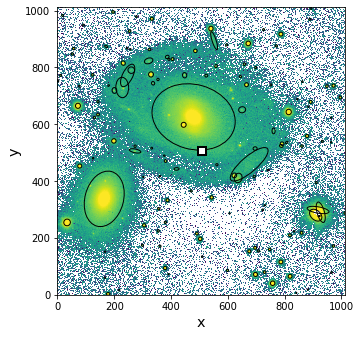

In [108]:
pscls[17].imgcutout['r'].show(show_sepobjects=True)

pickle.dump(pscls, open('../../../Data/pscls', 'wb'))

In [4]:
with open('../../../Data/pscls', 'rb') as f:
    pscls = pickle.load(f)

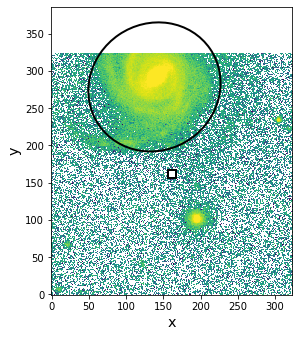

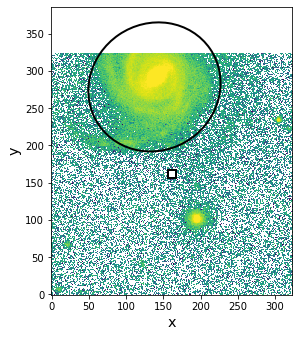

In [9]:
pscls[0].show()

### Low-z sample mass calculation

lowz_mass = []
for i in range(len(ra)):
    mm = massmeasure.MassMeasure(ra[i], dec[i], zcmb[i], pscls[i].imgcutout)
    lowz_mass.append(mm.get_hostgalaxy_params())

pickle.dump(lowz_mass, open('../../../Data/lowz_mass', 'wb'))

In [4]:
with open('../../../Data/lowz_mass', 'rb') as f:
    lowz_mass = pickle.load(f)

## Testing part

In [28]:
np.unique(redownload, return_counts=True)

(array([False,  True]), array([ 63, 107]))

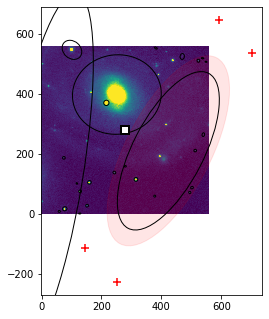

<Figure size 360x360 with 0 Axes>

In [43]:
i = 17
ind_xmin = np.argmin(vertices[i][:,0])
ind_xmax = np.argmax(vertices[i][:,0])
ind_ymin = np.argmin(vertices[i][:,1])
ind_ymax = np.argmax(vertices[i][:,1])

fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.12, 0.12, 0.8, 0.8])

mmcls[i].show(ax=ax, band='r',
              ellipse=True, scaleup=3,
              ell_color=(1, 0, 0, 0.1))
ax.scatter([vertices[i][ind_xmin][0], vertices[i][ind_xmax][0],
            vertices[i][ind_ymin][0], vertices[i][ind_ymax][0]],
           [vertices[i][ind_xmin][1], vertices[i][ind_xmax][1],
            vertices[i][ind_ymin][1], vertices[i][ind_ymax][1]],
           marker='+', s=80,
           color='r')
#hg_patch = Ellipse([hg_ell_test[0], hg_ell_test[1]],
#                   hg_ell_test[2]*4, hg_ell_test[3]*4,
#                   hg_ell_test[4], color='green')
#ax.add_patch(hg_patch)
fig.savefig(f'../../../Images/pdf/mass_cutout_size_{i}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/mass_cutout_size_{i}.png', bbox_inches='tight', dpi=600)

## `low-z` measured vs PS1 mass histogram

### Find closest PS1 catalog entry

In [32]:
p = panstarrs.PS1Target.from_coord(ra[i], dec[i])
p.download_catalog()

In [58]:
print(ra[i], dec[i])

7.46175 31.392744


## Hist

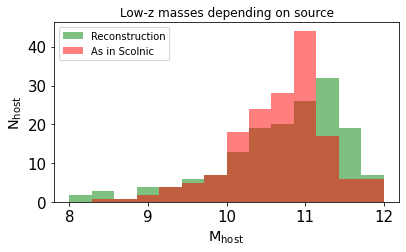

In [15]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

nb_bins = 14

where = np.where(lowz_mass[:, 0] > 8)

#h, r = np.histogram(lowz_mass[:, 0][where],
#                    range=[8, 12], bins=nb_bins)
#xbin = np.mean([r[:-1], r[1:]], axis=0)

ax.hist(lowz_mass[:, 0][where],
        range=[8, 12], bins=nb_bins,
        color='g', alpha=.5,
        label='Reconstruction')
        
#ax.errorbar(xbin, h, yerr=np.array(
#    [lowz_mass[i][1:] for i in range(len(h))]).T,
#            marker="None", ls="None",
#            lw=1, alpha=.5,
#            ecolor='g')

ax.hist(df.hostmass[df.hostmass > 8],
        range=[8,12], bins=nb_bins,
        color=colors['low-z'], alpha=.5,
        label='As in Scolnic')

ax.tick_params(labelsize=15)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host}$", fontsize="x-large")

ax.legend()

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_hist.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_hist.png', bbox_inches='tight', dpi=600)

## Scatter

In [49]:
np.shape(x_err)

(2, 163)

No handles with labels found to put in legend.


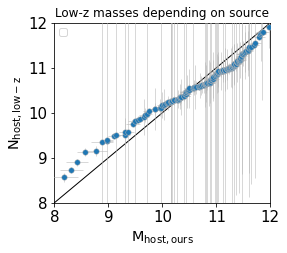

In [64]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

sort_recons = np.argsort(lowz_mass[:,0])
lowz_mass_sorted = lowz_mass[sort_recons]
select_recons = np.where(lowz_mass_sorted[:,0] > 8)
x_val = lowz_mass_sorted[:,0][select_recons][1:]
x_err = np.array([lowz_mass_sorted[i,1:] for i in range(len(x_val))]).T

sort_sco = np.argsort(df.hostmass.values)
sco_mass_sorted = df.hostmass.values[sort_sco]
select_sco = np.where(sco_mass_sorted > 8)
y_val = sco_mass_sorted[select_sco]
sco_masserr_sorted = df.hostmass_err.values[sort_sco]
y_err = sco_masserr_sorted[select_sco]

#ax.scatter(np.sort(np.concatenate((lowz_mass[:, 0], [5.0, 5.0]))),#[where],
#           np.sort(df.hostmass))

ax.scatter(x_val, y_val,
           marker='o', s=30,
           linewidths=.5,
           edgecolors='0.7',
           zorder=7)

ax.errorbar(x_val, y_val,
            xerr=x_err, yerr=y_err,
            ecolor='0.7', alpha=1, ms=0,
            lw=.5, ls='none', label=None, zorder=5)

ax.plot([8, 12], [8, 12], lw=1, color='k', zorder=1)

ax.tick_params(labelsize=15)

ax.set_xlim(8, 12)
ax.set_ylim(8, 12)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host, ours}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{host, low-z}$", fontsize="x-large")

ax.legend()

plt.title('Low-z masses depending on source')

fig.savefig('../../../Images/pdf/lowz_comp_scatter.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/lowz_comp_scatter.png', bbox_inches='tight', dpi=600)

In [69]:
np.unique(list(d[d['IDSURVEY'].isin([5, 61, 62, 63, 64, 65, 66])].HOST_LOGMASS_ERR > 1),
          return_counts=True)

(array([False,  True]), array([126,  46]))